In [11]:
%config IPCompleter.greedy=True
#%matplotlib inline
%matplotlib notebook
#%matplotlib widget # for ipympl (needs jupyterlab etc.)

import os, glob
from lammps_multistate_rods.tools.clusters import read_cluster_data, composition_by_states

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors

font = {'size' : 13}
matplotlib.rc('font', **font)

def calc_c(number, volume):
    '''
    Concentration in M/L for volume in nm^3
    '''
    return (10.0*number)/(6.022*volume)

base_dir = '/media/data_ntfs/PhD/simulation stuff/amyloids/data/soluble_only/5p_v3/'
data_dirs = []
data_dirs.extend(['cossq-1.0_3.00', 'LJ-0.6_5.5', 'LJ-1.0_3.9', 'LJ-1.75_3.25'])
data_dirs.extend(['cossq-1.0_3.25', 'LJ-0.6_6.0', 'LJ-1.0_4.25', 'LJ-1.75_3.5'])
data_dirs.extend(['cossq-1.0_3.37', 'LJ-0.6_6.25', 'LJ-1.0_4.42', 'LJ-1.75_3.62'])
data_dirs.extend(['cossq-1.0_3.50', 'LJ-0.6_6.5', 'LJ-1.0_4.6', 'LJ-1.75_3.75'])
data_dirs.extend(['cossq-1.0_3.75', 'LJ-0.6_7.0', 'LJ-1.0_5.0', 'LJ-1.75_4.0'])

In [2]:
# get all the data into appropriate structures

cell_sizes = set()
nums_cells = set()
all_data = {}
data_struct = ['ts', 'Vs', 'Nsols', 'Nmons', 'mic_stats', 'max_mic_size']

for data_dir in data_dirs:
    filepaths = sorted(glob.glob(os.path.join(base_dir, data_dir, '*_cluster_data')))
    n_sims = len(filepaths)
    for n in range(n_sims):
        params, tag = os.path.basename(filepaths[n]).split('_')[:2]
        cell_size, num_cells = tuple(map(float, params.split('-')))
        cell_sizes.add(cell_size)
        nums_cells.add(num_cells)
        key = (data_dir, cell_size, num_cells)
        if not key in all_data:
            all_data[key] = {}
        data = []
        all_data[key][tag] = data
    
        temp = read_cluster_data(filepaths[n])
        n_snapshots = len(temp[0])
        cluster_compositions = composition_by_states(temp[2])
        data.append(np.array(temp[0])) #timesteps
        data.append(np.array(map(lambda box_dims: reduce(lambda x,y: x*y, box_dims), temp[1]))) #volumes
        data.append(np.zeros(n_snapshots)) #total soluble rods
        data.append(np.zeros(n_snapshots)) #free soluble monomers
        data.append(np.zeros(n_snapshots)) #total clusters (of any size, including free)
        data.append([None]*n_snapshots) #lists of (size,occurrences) pairs
        data.append(0) #max micelle size
    
        for i in range(n_snapshots):
            data[5][i] = []
            for cluster_ID, cluster_composition in cluster_compositions[i].iteritems():
                if None in cluster_composition:
                    raise Exception('Unknown rod state/molecule in a cluster!')
                num_sols = cluster_composition.get(0, 0)
                num_betas = cluster_composition.get(1, 0)
                cluster_size = num_sols + num_betas
                data[2][i] += num_sols
                if num_betas >= 1:
                    pass #fibril or a micelle with a single converted rod
                else:
                    if cluster_size == 1:
                        data[3][i] += 1
                    data[4][i] += 1
                    data[5][i].append(cluster_size) #includes free monomers
            max_i = max(data[5][i])
            data[6] = max_i if max_i > data[6] else data[6]
            data[5][i] = zip(*np.unique(data[5][i], return_counts=True))

cell_sizes = sorted(cell_sizes)
nums_cells = sorted(nums_cells)

In [3]:
# process the data into useful stuff

avg_over = 100
cmc_stats = {}
distributions = {}
for key in all_data.keys():
    n_sims = len(all_data[key])
    max_i = min(map(len, [data[0] for data in all_data[key].values()]))
    common_ts = all_data[key].values()[0][0][:max_i]
    
    all_total_cs = np.concatenate([map(lambda n: calc_c(n, data[1][0]), data[2][max_i-avg_over:max_i])
                    for data in all_data[key].values()])
    all_free_cs = np.concatenate([map(lambda n: calc_c(n, data[1][0]), data[3][max_i-avg_over:max_i])
                    for data in all_data[key].values()])
    total_sols = (np.mean(all_total_cs), np.std(all_total_cs))
    free_sols = (np.mean(all_free_cs), np.std(all_free_cs))
    cmc_stats[key] = (common_ts, total_sols, free_sols)
    
    max_mic_size = max([data[6] for data in all_data[key].values()])
    agg_occurr = [None]*avg_over
    for i in range(avg_over):
        agg_occurr[i] = np.zeros((max_mic_size, n_sims), float)
        for j in range(n_sims):
            t = max_i - avg_over + i
            data = all_data[key].values()[j]
            for size, occurr in data[5][t]:
                agg_occurr[i][size-1,j] = float(occurr)/data[4][t]#float(occurr*size)/data[2][t]
    agg_occurr = np.concatenate(agg_occurr, 1)
    avg_dist = (np.mean(agg_occurr, 1), np.std(agg_occurr, 1))
    
    distributions[key] = (common_ts, avg_dist, max_mic_size)

<IPython.core.display.Javascript object>


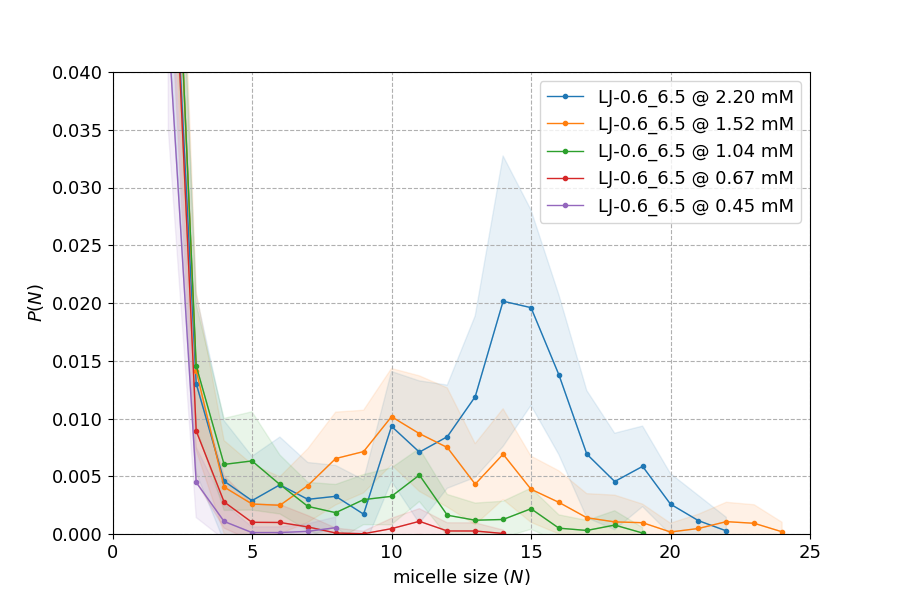

In [12]:
# draw the distribution (& numbers of total and free solubles in time) for a single simulation
data_dir = data_dirs[13]
num_cells = nums_cells[0]

fig = plt.figure('Averaged micelle size distributions for {}'.format(data_dir), figsize=[9,6])
ax = plt.axes()

for i in range(5):
    cell_size = cell_sizes[i]
    try:
        key = (data_dir, cell_size, num_cells)
        data = all_data[key]
    except KeyError:
        print "ERROR: No simulations with those parameters!"
        assert False

    common_ts, avg_dist, max_mic_size = distributions[key]
    c = calc_c(data.values()[0][2][0], data.values()[0][1][0])*1000
    sizes = range(1, max_mic_size+1)
    
    color = colors.to_rgb(cm.tab10(i))
    color_fill = (color + (0.1,))
    ax.plot(sizes, avg_dist[0], '.-', lw=1, color=color,
            label=r'{} @ {:.2f} mM'.format(data_dir, c))
    ax.fill_between(sizes, avg_dist[0], avg_dist[0]+avg_dist[1], color=color_fill)
    ax.fill_between(sizes, avg_dist[0], avg_dist[0]-avg_dist[1], color=color_fill)

ax.set_xlabel(r'micelle size ($N$)')
ax.set_ylabel(r'$P(N)$', rotation='vertical')
ax.set_xlim(0, 25)
ax.set_ylim(0.0, 0.04)
ax.grid(linestyle='--')
ax.legend(loc='upper right')

plt.show()

<IPython.core.display.Javascript object>


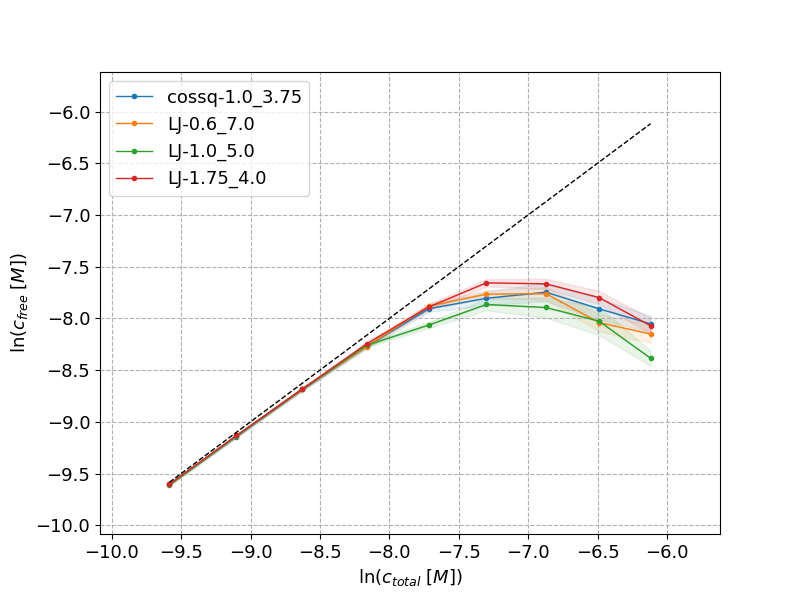

In [17]:
# draw free vs. total concentration (CMC graph)

num_cells = nums_cells[0]

xs = []
xdevs = []
ys = []
ydevs = []
for data_dir in data_dirs:
    xs.append([])
    xdevs.append([])
    ys.append([])
    ydevs.append([])
    for cell_size in cell_sizes:
        key = (data_dir, cell_size, num_cells)
        try:
            common_ts, total_sols, free_sols = cmc_stats[key]
        except:
            continue
        xs[-1].append(np.log(total_sols[0]))
        xdevs[-1].append(total_sols[1]/total_sols[0])
        ys[-1].append(np.log(free_sols[0]))
        ydevs[-1].append(free_sols[1]/free_sols[0])
    xs[-1] = np.array(xs[-1])
    xdevs[-1] = np.array(xdevs[-1])
    ys[-1] = np.array(ys[-1])
    ydevs[-1] = np.array(ydevs[-1])
xmin = min(map(min, xs))
xmax = max(map(max, xs))

fig = plt.figure('CMC', figsize=(8,6))
ax = plt.axes()
for i in range(16, 20):
    color = colors.to_rgb(cm.tab10(i%4))
    color_fill = (color + (0.1,))
    #ax.errorbar(xs[i], ys[i], xerr=xdevs[i], fmt='.-', capsize=4, lw=1.0, color=color, label=data_dirs[i])
    ax.plot(xs[i], ys[i], '.-', lw=1.0, color=color, label=data_dirs[i])
    ax.fill_between(xs[i], ys[i], ys[i]+ydevs[i], color=color_fill)
    ax.fill_between(xs[i], ys[i], ys[i]-ydevs[i], color=color_fill)
plt.plot((xmin, xmax), (xmin, xmax), 'k--', lw=1.0)
ax.set_xlabel(r'$\ln\left(c_{total}\;[M]\right)$')
ax.set_ylabel(r'$\ln\left(c_{free}\;[M]\right)$', rotation='vertical')
plt.axis(ymin=xmin-0.5, ymax=xmax+0.5, xmin=xmin-0.5, xmax=xmax+0.5)
ax.grid(linestyle='--')
ax.legend(loc='upper left')

plt.show()